In [2]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [3]:

u_inf = 1.0 

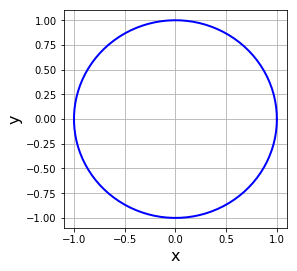

In [4]:
# задаем параметры цилиндра
R = 1.0                                     # радиус
# угловая координата в радианах
theta = numpy.linspace(0, 2*math.pi, 100)   
# цилиндр в декартовых координатах
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   

# рисуем цилиндр
size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [5]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        # контрольная точка (центр панели)
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2    
        # длина панели
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                         # интенсивность источника
        self.vt = 0.                            # касательная скорость
        self.v = 0.
        self.u = 0.
        self.cp = 0.                            # коэффициент давления

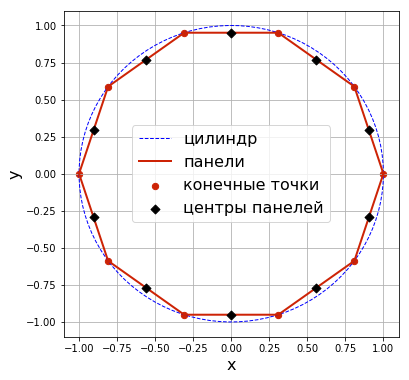

In [6]:
N_panels = 10                    # желаемое число панелей

# задаем конечные точки панелей
x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

# определяем панели
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# рисуем панели
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='цилиндр',
            color='b', linestyle='--', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='панели',
            color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='конечные точки',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='центры панелей', marker = 'D',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);


In [7]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [8]:
# вычисляем матрицу влияния источников
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_normal(p_i, p_j)

# вычисляем правую столбец правой части системы уравнений
b = - u_inf * numpy.cos([p.beta for p in panels])

In [9]:
# решаем систему линейных уравнений
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [10]:
def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ( (-(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [11]:
# вычисляем матрицу системы линейных уравнений
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_tangential(p_i, p_j)

# вычисляем столбец -- правую часть
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# вычисляем касательную скорость в центрах панелей
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [12]:
# рассчитываем коэффициент давления
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

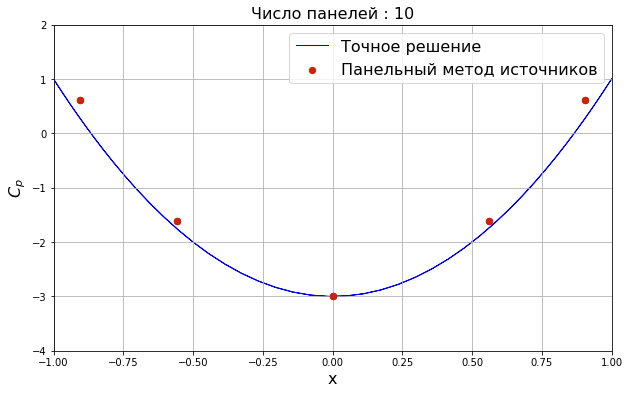

In [13]:

# вычисляем аналитическое значение коэффициента давления на цилиндре
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# рисуем распределение коэффициента давления на поверхности
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='Точное решение',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='Панельный метод источников',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Число панелей : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

## Контрольное задание

In [14]:
def integral_decard_v( p_j, x, y):
    def integrand(s):
        return ( (
                  +(y-(p_j.ya+math.cos(p_j.beta)*s)))
                /((x-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(y-(p_j.ya+math.cos(p_j.beta)*s))**2) )
       # return ((y - (p_j.ya+math.cos(p_j.beta)*s))/((x - (p_j.xa-math.sin(p_j.beta))*s)**2 + (y - (p_j.ya+math.cos(p_j.beta)*s)**2)))
    
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [15]:
def integral_decard_u( p_j, x, y):
    def integrand(s):
        return ( (
                  +(x-(p_j.xa-math.sin(p_j.beta)*s)))
                /((x-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(y-(p_j.ya+math.cos(p_j.beta)*s))**2) )
       # return ((y - (p_j.ya+math.cos(p_j.beta)*s))/((x - (p_j.xa-math.sin(p_j.beta))*s)**2 + (y - (p_j.ya+math.cos(p_j.beta)*s)**2)))
    
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [16]:
N = 50                                # Число точек в каждом направлении
x_start, x_end = -1.5, 1.5            # граница по x
y_start, y_end = -1.5, 1.5            # граница по y
x = numpy.linspace(x_start, x_end, N)    # вычисляем одномерный массив x
y = numpy.linspace(y_start, y_end, N)    # вычисляем одномерный массив y
X, Y = numpy.meshgrid(x, y)              # создаем расчетную сетку
        

In [17]:
panels

array([<__main__.Panel object at 0x000001CA38509DA0>,
       <__main__.Panel object at 0x000001CA38509F60>], dtype=object)

In [18]:
V = numpy.zeros((N, N))

for panel in panels:
    
    for j, y_ in enumerate(y):
        for i, x_ in enumerate(x):
            V[i,j] += panel.sigma/(2*math.pi)*integral_decard_v(panel, x_, y_)


In [19]:
U = numpy.ones((N, N))

for panel in panels:
    for j, y_ in enumerate(y):
        for i, x_ in enumerate(x):

            U[j,i] += panel.sigma/(2*math.pi)*integral_decard_u(panel, x_, y_)

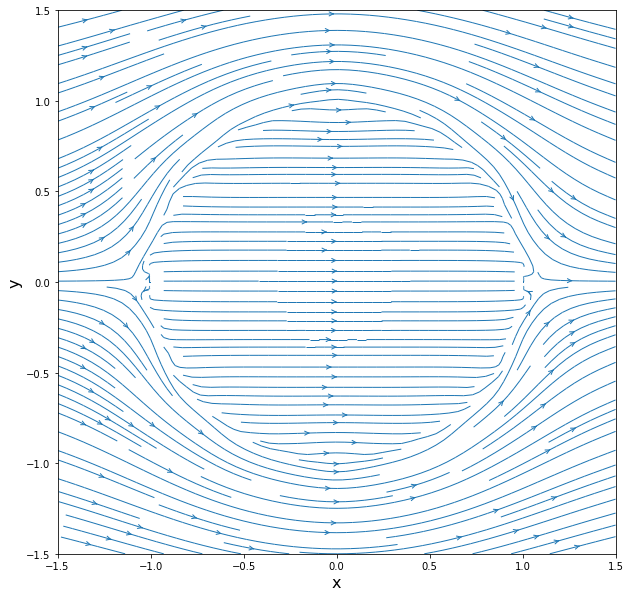

In [20]:
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, U, V, density=2, linewidth=1, arrowsize=1,\
                  arrowstyle='->')
